In [1]:
%pylab inline
import random
import cv2
import pandas as pd
import os
from glob import glob

Populating the interactive namespace from numpy and matplotlib


Steering angle distribution
===========================

In [2]:
dataDIR = 'data'
logFile = os.path.join(dataDIR, 'driving_log.csv')
raw_data = pd.read_csv(logFile)
raw_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG\center_2016_12_01_13_30_48_287.jpg,IMG\left_2016_12_01_13_30_48_287.jpg,IMG\right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG\center_2016_12_01_13_30_48_404.jpg,IMG\left_2016_12_01_13_30_48_404.jpg,IMG\right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG\center_2016_12_01_13_31_12_937.jpg,IMG\left_2016_12_01_13_31_12_937.jpg,IMG\right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG\center_2016_12_01_13_31_13_037.jpg,IMG\left_2016_12_01_13_31_13_037.jpg,IMG\right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG\center_2016_12_01_13_31_13_177.jpg,IMG\left_2016_12_01_13_31_13_177.jpg,IMG\right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
print('Number of images per camera in the log file: {}'.format(
                                                    raw_data.shape[0]))

Number of images per camera in the log file: 13647


In [4]:
raw_data['steering'].describe()

count    13647.000000
mean        -0.003444
std          0.240027
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: steering, dtype: float64

The data is skewed towards small steering angles. Below is the histogram on linear scale and log scale to confirm this observation.

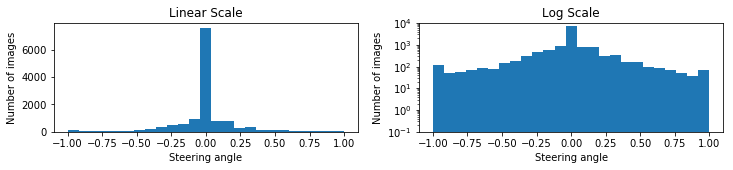

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 2))
for ax in axes:
    ax.hist(raw_data['steering'], bins=25)
    ax.set_xlabel('Steering angle')
    ax.set_ylabel('Number of images')
    
axes[1].set_ylim([0.1, 10000])
axes[1].set_yscale('log')
axes[1].set_title('Log Scale')
axes[0].set_title('Linear Scale')
plt.show()

Let's check if the images in the dataset are actually consistent with the information in the log file:

In [17]:
left_img_files = glob(os.path.join(dataDIR, 'IMG\\left*.jpg'))
center_img_files = glob(os.path.join(dataDIR, 'IMG\\center*.jpg'))
right_img_files = glob(os.path.join(dataDIR, 'IMG\\right*.jpg'))

In [18]:
# Check if every shot has all the three camera angles and no images 
#are missing

for center_file in center_img_files:
    base_path, img_index = center_file.split('center_')
    left_file = os.path.join(base_path, 'left_' + img_index)
    right_file = os.path.join(base_path, 'right_' + img_index)
    assert left_file in left_img_files, left_file+' missing'
    assert right_file in right_img_files, right_file+' missing'
    
print("All shots have three camera angles.")

All shots have three camera angles.


In [20]:
number_of_images = len(center_img_files)
print('{} images in the image dataset for each camera angle'.format(
                                                     number_of_images))

assert number_of_images == raw_data.shape[0], 'Number of images do not\
                                              match with that in log file'
print('Number of images consistent with log file')

# get sample image size
img = cv2.imread(center_img_files[0])
print('Size of a sample image is : {}'.format(img.shape))

13647 images in the image dataset for each camera angle
Number of images consistent with log file
Size of a sample image is : (160, 320, 3)


Some Image visualization
========================

## Helper function to display three random images for each of the three camera angles

In [25]:
camera_positions = ['left', 'center', 'right']

def generate_image(img_index, camera_position='center'):
    img_data = raw_data.iloc[img_index]
    steer = img_data['steering']
    file_name = os.path.join(dataDIR, img_data[camera_position].strip())
    img = plt.imread(file_name)
    #image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

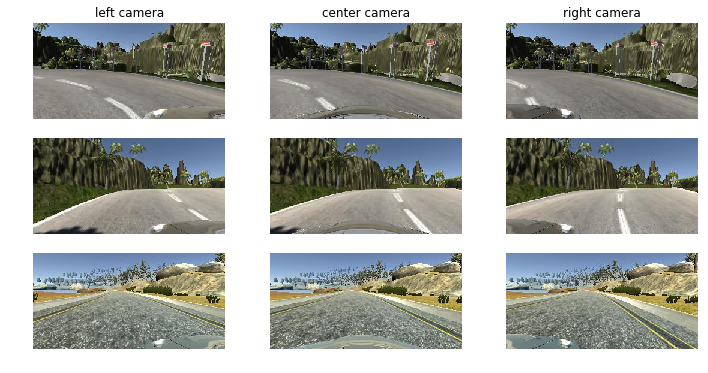

In [26]:
# plot some random images for different camera angles
fig, axes = plt.subplots(3, 3, figsize=(12, 6))
for pos, ax in zip(camera_positions, axes[0,:]):
    ax.set_title(pos + ' camera')
    
for ax in axes:
    img_index = random.randrange(number_of_images)
    for a, pos in zip(ax, camera_positions):
        img = generate_image(img_index, camera_position = pos)
        a.imshow(img)
        a.axis('off')